## STD project

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

import random as rnd

## Dataset utils

In [5]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

## Train utils

In [6]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100


def train_epoch(net, train_iter, loss, optimizer, device):  
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100


def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all, test_acc, test_loss


def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')


def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1) 
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss') 
    plt.title('Training and validation loss') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.legend()  
    plt.show()


def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy') 
    plt.legend()
    plt.show()

## LeNet

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

## Mess the data

In [50]:
from torchvision.utils import _log_api_usage_once

class TargetTransform():
    def __init__(self, p):
        self.p = p

    def __call__(self, n):
        change_label = rnd.random() < self.p
        return (rnd.randint(0, 9) if change_label else n)


def load_data_fashion_mnist(batch_size, resize=None, error_rate=0.0):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    target_transform = TargetTransform(error_rate)

    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, target_transform=target_transform, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=0),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=0),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [51]:
rate_errors = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [ ]:
batch_size, lr, num_epochs = 256, 0.9, 10

train_loss_all = []
train_acc_all = []
val_loss_all = []
val_acc_all = []
test_loss_all = []
test_acc_all = []

for error_rate in rate_errors:
    train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size, error_rate=error_rate)
    train_loss, train_acc, val_loss, val_acc, test_acc, test_loss = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min
    train_loss_all.append(train_loss)
    train_acc_all.append(train_acc)
    val_loss_all.append(val_loss)
    val_acc_all.append(val_acc)
    test_loss_all.append(test_loss)
    test_acc_all.append(test_acc)


In [42]:
import numpy as np

buffer_train_val = np.array([train_loss_all, train_acc_all, val_loss_all, val_acc_all])
buffer_test = np.array([test_loss_all, test_acc_all])

buffer_train_val.tofile("buffer_train_val.numpy")
buffer_test.tofile("buffer_test.numpy")

[[[ 2.31714912  2.30564204]
  [ 2.32021208  2.306243  ]]

 [[10.09        9.978     ]
  [10.146      10.01      ]]

 [[ 2.31006898  2.31097072]
  [ 2.31643114  2.30358204]]

 [[10.46       10.49      ]
  [10.28       10.25      ]]]
(4, 2, 2)


[[[ 0.54457868]
  [ 0.63853655]
  [ 0.75382143]
  [ 0.9068783 ]
  [ 1.02503762]
  [ 1.16203636]
  [ 1.41213337]
  [ 1.68542035]
  [ 2.3030839 ]
  [ 2.30554531]
  [ 2.30375065]]

 [[79.6       ]
  [76.63      ]
  [78.22      ]
  [74.09      ]
  [73.88      ]
  [72.75      ]
  [59.61      ]
  [56.34      ]
  [10.        ]
  [10.        ]
  [10.        ]]]


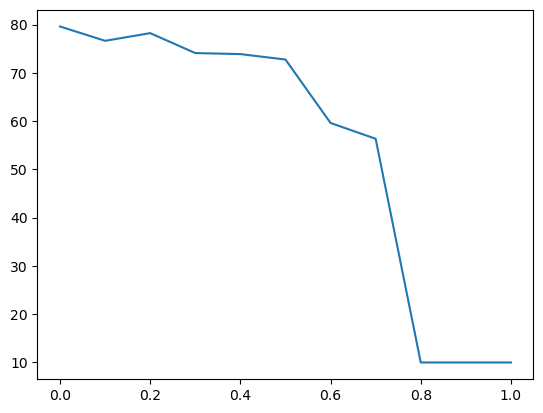

In [60]:
# buffer_train_val = np.fromfile("buffer_train_val.numpy")
buffer_test = np.fromfile("fashionMnist_iteration1/buffer_test.numpy")

# buffer_train_val = buffer_train_val.reshape((4, 2, 2))
buffer_test = buffer_test.reshape((2, 11, 1))
# print(buffer_train_val)
print(buffer_test)

import matplotlib.pyplot as plt

plt.plot(rate_errors, buffer_test[1])